![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [21]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [7]:
# Celda 1.1
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


A partir del promedio de la variable total (cantidad total de alquileres por hora) por cada valor de la variable season, se evidencia que la temporada con mayor valor promedio de alquiler de bicicletas es la 3 que corresponde al verano, seguida por las temporadas 2 (primavera), 4 (otoño) y 1 (invierno). Tomando como referencia el valor de la mediana (50%) de alquileres por temporada se mantiene el orden a nivel de temporadas. Lo anterior podría estar correlacionado a las temperaturas de las temporadas, en donde aquellas con temperaturas mayores estan asociadas a un mayor promedio de alquileres de bicicletas por hora, teniendo en cuenta el contexto del negocio del alquiler de bicicletas y que éste implica el uso de bicicletas en exteriores. 

In [8]:
# Celda 1.2
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


Con el promedio de alquileres para cada hora se observa una diferencia en escala de los valores entre las 7 y las 22 respecto al complemento horario entre las 23 y las 6 horas, en donde el rango de 7-22 está a nivel de cientos y el de 23-6 a nivel de decenas. Así mismo, la hora con mayor promedio es la 17 y la de menor promedio es la 4. Lo anterior sugiere alguna correlación entre el promedio de alquileres por hora y el momento del día (día,tarde,noche)

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

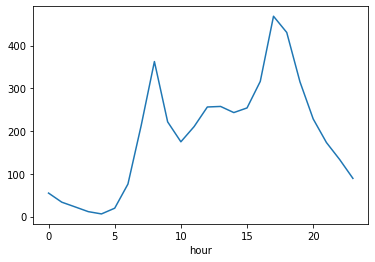

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

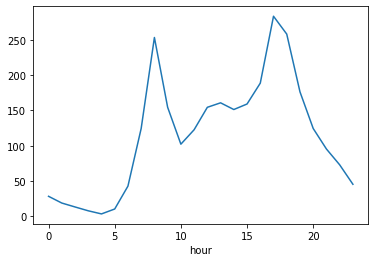

In [11]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']==1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

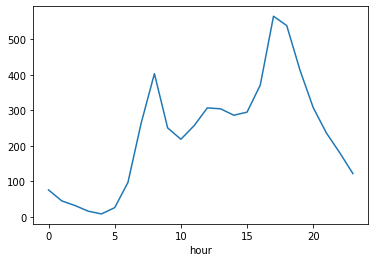

In [12]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']==3].groupby('hour').total.mean().plot()

Comparando la gráfica general y las gráficas para las temporadas invierno y verano, se observa un patrón en la distribución del promedio de alquileres por hora compuesto por 3 picos en el rango de horas que se componen de dos picos exteriores predominantes y un tercer pico entre el rango de los dos exteriores. Lo anterior podría estar correlacionado a los horarios laborales y los momentos de principal uso de bicicletas como medio de desplazamiento. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [47]:
X = bikes[['season','hour']]
X = pd.get_dummies(X, columns=['season'], drop_first=True)
y = bikes['total']
model = LinearRegression()
model.fit(X, y)
coef_table = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                          columns=['Variable', 'Coefficient'])
print(coef_table)

    Variable  Coefficient
0  intercept    -6.430262
1       hour    10.545206
2   season_2   100.317232
3   season_3   119.467550
4   season_4    84.083118


A partir de los coeficientes se puede observar que los coeficientes para las variables correspondientes a las temporadas mantienen el orden identificado en el punto 1 a partir de los promedios de alquiler por hora y por temporada, siendo la variable season_3 asociada al verano la que tiene mayor valor, seguida por season_2 (primavera) y season 4 (otoño). En terminos de la variable hora se evidencia un coeficiente positivo de valor 10.5, lo que podría indicar que a mayor hora mayor sería el número de alquileres promedio. 

En este caso se evidencia una limitación sobre el análisis planteado sobre la variable hora y el número de alquileres, ya que con la regresión lineal se establece un crecimiento constante con un coeficiente de 10.5, lo cual no llega a atrapar los patrones evidenciados en el punto 3, donde se tienen horas pico del día con un mayor número promedio de alquileres por hora.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [87]:
# Celda 4
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    j, split, gain = best_split(X, y, num_pct)
    
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 0.5,
 'level': 0,
 'split': [26, 2980.6923531436364],
 'n_samples': 6000,
 'gain': 0.0348732856787054,
 'sl': {'y_pred': 0,
  'y_prob': 0.35544155368266767,
  'level': 1,
  'split': [21, 920.0909090909092],
  'n_samples': 2727,
  'gain': 0.008693191616418905,
  'sl': {'y_pred': 0,
   'y_prob': 0.4052964881980426,
   'level': 2,
   'split': [25, 3572.437025628182],
   'n_samples': 1735,
   'gain': 0.010920047130314081,
   'sl': {'y_pred': 0,
    'y_prob': 0.3080568720379147,
    'level': 3,
    'split': -1,
    'n_samples': 631,
    'gain': 0.01313875257134478},
   'sr': {'y_pred': 0,
    'y_prob': 0.46112115732368897,
    'level': 3,
    'split': -1,
    'n_samples': 1104,
    'gain': 0.006831363870773988}},
  'sr': {'y_pred': 0,
   'y_prob': 0.2686116700201207,
   'level': 2,
   'split': [16, 1.0],
   'n_samples': 992,
   'gain': 0.014948961407816874,
   'sl': {'y_pred': 0,
    'y_prob': 0.2192513368983957,
    'level': 3,
    'split': -1,
    'n_samples': 746

In [88]:
def contar_nodos_finales(tree):
    if tree['split'] == -1:
        return 1
    else:
        return contar_nodos_finales(tree['sl']) + contar_nodos_finales(tree['sr'])
contar_nodos_finales(tree)

8

Se construyó un arbol manualmente con una profundidad de 3, obteniendo como resultado 8 nodos finales.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

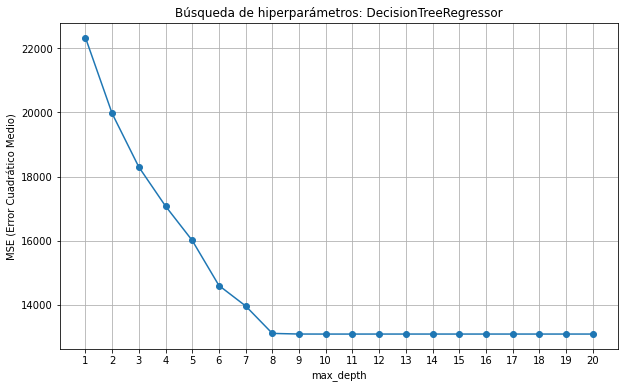

La profundidad óptima del árbol es: 10


DecisionTreeRegressor(max_depth=10, random_state=1)

In [62]:
# Celda 5
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

max_depth_range = range(1, 21)
mse_scores = []

for depth in max_depth_range:
    reg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse_scores.append(-cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, mse_scores, marker='o')
plt.title('Búsqueda de hiperparámetros: DecisionTreeRegressor')
plt.xlabel('max_depth')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.xticks(max_depth_range)
plt.grid(True)
plt.show()

optimal_depth = max_depth_range[np.argmin(mse_scores)]
print(f"La profundidad óptima del árbol es: {optimal_depth}")

dt = DecisionTreeRegressor(max_depth=optimal_depth, random_state=1)
dt.fit(X_test, y_test)

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)
coef_table = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [lr.intercept_] + lr.coef_.tolist()),
                          columns=['Variable', 'Coefficient'])
print(coef_table)

    Variable  Coefficient
0  intercept    -7.025709
1       hour    10.644067
2   season_2    95.372680
3   season_3   118.947054
4   season_4    81.801224


In [63]:
from sklearn.metrics import mean_squared_error

y_pred_dt = dt.predict(X_test)
y_pred_lr = lr.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mse_lr = mean_squared_error(y_test, y_pred_lr)

(mse_dt, mse_lr)

(12208.307171851453, 26626.84354425434)

En primer lugar se generó una muestra de entrenamiento y una de validación, con la muestra de entrenamiento se realizó la busqueda del parámetro de profundidad máxima obteniendo un valor de 10. Finalmente, se entrenó un arbol de decisión con profundidad máxima de 10 y un modelo de regresión lineal a partir de la muestra de entrenamiento. Finalmente, se realizó la predicción con ambos modelos sobre la muestra de validación, obteniendo un MSE de 12208.3 para el modelo de árbol de decisión y un MSE de 26626.8 para el modelo de regresión lineal. Con lo anterior se determina que el modelo de árbol de decisión tuvo un mejor desempeño que la regresión lineal. 

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [64]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [65]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [66]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [68]:
# Celda 6
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import scipy.stats as stats

param_distributions = {
    'max_depth': stats.randint(1, 41), 
    'min_samples_leaf': stats.randint(1, 21)
}

tree_clf = RandomizedSearchCV(DecisionTreeClassifier(random_state=1),
                              param_distributions=param_distributions,
                              n_iter=100,
                              cv=5,
                              scoring='accuracy',
                              random_state=1)
tree_clf.fit(X_train, y_train)
best_tree_clf = DecisionTreeClassifier(max_depth=tree_clf.best_params_['max_depth'],
                                       min_samples_leaf=tree_clf.best_params_['min_samples_leaf'],
                                       random_state=1)
best_tree_clf.fit(X_train, y_train)

log_reg = LogisticRegression(max_iter=10000, random_state=1)
log_reg.fit(X_train, y_train)

y_pred_tree = best_tree_clf.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_score_tree = f1_score(y_test, y_pred_tree, average='binary')

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_score_log_reg = f1_score(y_test, y_pred_log_reg, average='binary')

print(f"Árbol de decisión - Mejor profundidad: {tree_clf.best_params_['max_depth']}, Mejor tamaño mínimo de hoja: {tree_clf.best_params_['min_samples_leaf']}")
print(f"Árbol de decisión - Accuracy: {accuracy_tree:.4f}, F1-Score: {f1_score_tree:.4f}")
print(f"Regresión logística - Accuracy: {accuracy_log_reg:.4f}, F1-Score: {f1_score_log_reg:.4f}")

Árbol de decisión - Mejor profundidad: 1, Mejor tamaño mínimo de hoja: 17
Árbol de decisión - Accuracy: 0.6453, F1-Score: 0.6449
Regresión logística - Accuracy: 0.6233, F1-Score: 0.6106


En principio se realizó una busqueda aleatoria de los parametros de profundidad máxima y tamaño mínimo de hoja para el árbol de decisión, obteniendo los valores de 1 y 17 respectivamente. Se entrenó el modelo de árbol de decisión y el modelo de regresión logística y se calcularon el Accuracy y el F1-score con los resultados de las predicciones con la muestra de validación. Los resultados indican que el modelo de árbol de decisión superó ligeramente a la regresión logística en terminos de Accuracy y F1-Score con valores de 64,5% y 64,4% respectivamente. 

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [73]:
# Celda 7
n_estimators = 300
np.random.seed(123)
n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees_max_depth = {}
for i in range(100):
    trees_max_depth[i] = DecisionTreeClassifier(max_depth=1, random_state=seeds[i])  
    trees_max_depth[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

trees_min_samples_leaf = {}
for i in range(100, 200):
    trees_min_samples_leaf[i] = DecisionTreeClassifier(min_samples_leaf=17, random_state=seeds[i]) 
    trees_min_samples_leaf[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

log_regs = {}
for i in range(200, 300):
    log_regs[i] = LogisticRegression(random_state=seeds[i], max_iter=1000)
    log_regs[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    if i < 200:
        model = trees_max_depth[i] if i < 100 else trees_min_samples_leaf[i]
    else:
        model = log_regs[i]
    y_pred_df.iloc[:, i] = model.predict(X_test)

y_pred_total = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(int)

def calcular_accuracy_y_f1_score(y_pred_df, y_test, start_idx, end_idx):
    y_pred = (y_pred_df.iloc[:, start_idx:end_idx].sum(axis=1) >= (end_idx - start_idx) / 2).astype(int)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return f1, accuracy

f1_depth, accuracy_depth = calcular_accuracy_y_f1_score(y_pred_df, y_test, 0, 100)
f1_leaf, accuracy_leaf = calcular_accuracy_y_f1_score(y_pred_df, y_test, 100, 200)
f1_logreg, accuracy_logreg = calcular_accuracy_y_f1_score(y_pred_df, y_test, 200, 300)

print(f"Árboles con max_depth - F1-Score: {f1_depth:.4f}, Accuracy: {accuracy_depth:.4f}")
print(f"Árboles con min_samples_leaf - F1-Score: {f1_leaf:.4f}, Accuracy: {accuracy_leaf:.4f}")
print(f"Regresiones Logísticas - F1-Score: {f1_logreg:.4f}, Accuracy: {accuracy_logreg:.4f}")

print("Ensamble Combinado - F1-Score:", f1_score(y_test, y_pred_total))
print("Ensamble Combinado - Accuracy:", accuracy_score(y_test, y_pred_total))


Árboles con max_depth - F1-Score: 0.6449, Accuracy: 0.6453
Árboles con min_samples_leaf - F1-Score: 0.6649, Accuracy: 0.6640
Regresiones Logísticas - F1-Score: 0.6037, Accuracy: 0.6167
Ensamble Combinado - F1-Score: 0.6219426974143956
Ensamble Combinado - Accuracy: 0.6393333333333333


Se construyeron 100 modelos de árbol de decisión con profundidad máxima de 1, 100 modelos con 17 como tamaño mínimo de hoja y 100 regresiones logísticas. Se realizó el ensamblaje para cada grupo (árboles con profundidad máxima, árboles con tamaño mínimo de hojas y regresiones logísticas) usando la votación mayoritaria y se realizó el ensamblaje de los 300 modelos usando el mismo método. Los resultados muestran un mejor desempeño en términos de Accuracy y F1-score para el ensamble de los 100 árboles de decisión con tamaño mínimo de hojas obteniendo un valor de 66.4% para ambas métricas. El ensamblaje de los 300 modelos no llega a ser mejor que los dos tipos de árboles en ensamblaje, solo es ligeramente mejor que el emsamble de las regresiones logísticas  

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [79]:
# Celda 8
weights_depth = [accuracy_score(y_train.iloc[samples[i]], trees_max_depth[i].predict(X_train.iloc[samples[i]])) for i in range(100)]
weights_leaf = [accuracy_score(y_train.iloc[samples[i-100]], trees_min_samples_leaf[i].predict(X_train.iloc[samples[i-100]])) for i in range(100, 200)]
weights_logreg = [accuracy_score(y_train.iloc[samples[i-200]], log_regs[i].predict(X_train.iloc[samples[i-200]])) for i in range(200, 300)]

weights = np.array(weights_depth + weights_leaf + weights_logreg)
weights /= np.sum(weights)
weighted_votes = y_pred_df.dot(weights)
threshold = 0.5
y_pred_weighted = (weighted_votes >= threshold).astype(int)

f1_weighted = f1_score(y_test, y_pred_weighted)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)

def mostrar_metricas_por_grupo(y_pred_df, weights, start_idx, end_idx, y_test, modelo_nombre):
    grupo_weights = weights[start_idx:end_idx]
    grupo_weights /= np.sum(grupo_weights)
    grupo_weighted_votes = y_pred_df.iloc[:, start_idx:end_idx].dot(grupo_weights)
    grupo_y_pred_weighted = (grupo_weighted_votes >= 0.5).astype(int)
    grupo_f1_weighted = f1_score(y_test, grupo_y_pred_weighted)
    grupo_accuracy_weighted = accuracy_score(y_test, grupo_y_pred_weighted)
    print(f"{modelo_nombre} - Votación Ponderada - F1-Score: {grupo_f1_weighted:.4f}, Accuracy: {grupo_accuracy_weighted:.4f}")

mostrar_metricas_por_grupo(y_pred_df, weights, 0, 100, y_test, "Árboles con max_depth")
mostrar_metricas_por_grupo(y_pred_df, weights, 100, 200, y_test, "Árboles con min_samples_leaf")
mostrar_metricas_por_grupo(y_pred_df, weights, 200, 300, y_test, "Regresiones Logísticas")
print(f"Ensamble Combinado - Votación Ponderada - F1-Score: {f1_weighted:.4f}, Accuracy: {accuracy_weighted:.4f}")

Árboles con max_depth - Votación Ponderada - F1-Score: 0.6449, Accuracy: 0.6453
Árboles con min_samples_leaf - Votación Ponderada - F1-Score: 0.6631, Accuracy: 0.6633
Regresiones Logísticas - Votación Ponderada - F1-Score: 0.6032, Accuracy: 0.6167
Ensamble Combinado - Votación Ponderada - F1-Score: 0.6199, Accuracy: 0.6387


Se calcularon los pesos para cada modelo usando como métrica el Accuracy. Con dichos pesos se calculó la votación ponderada para cada tipo de modelo y para los 300 modelos combinados, en donde se mantiene el grupo de los 100 árboles con tamaño mínimo de hoja como el mejor en terminos de F1-score y Accuracy como en el caso de la votación mayoritaria. Al ensamble de todos los 300 modelos con votación ponderada le va ligeramente peor comparado con el ensamble de los 300 modelos con votación mayoritaria.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

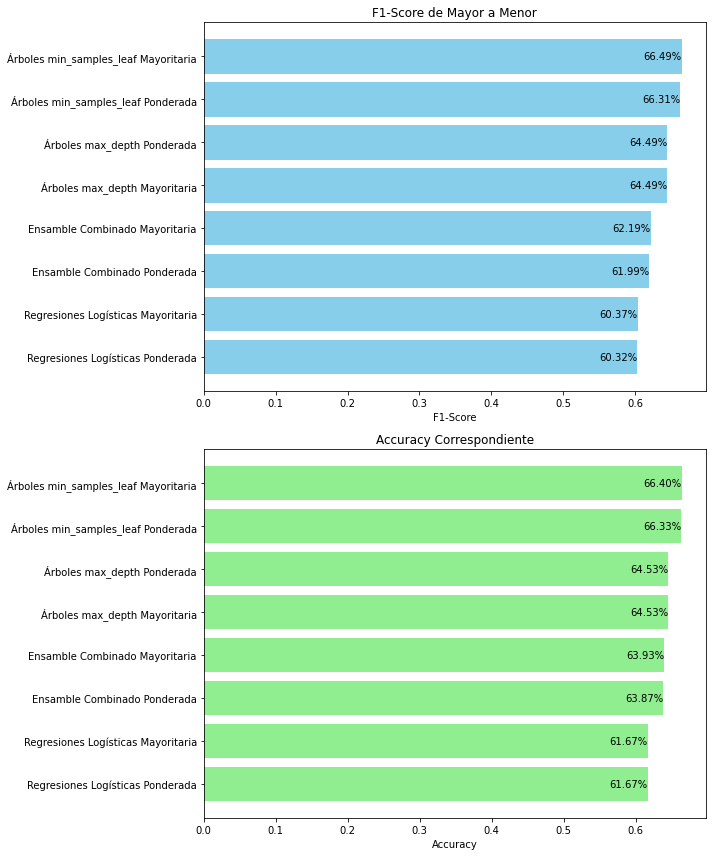

In [86]:
# Celda 9
f1_scores = [0.6449, 0.6649, 0.6037, 0.6219, 0.6449, 0.6631, 0.6032, 0.6199]
accuracy_scores = [0.6453, 0.6640, 0.6167, 0.6393, 0.6453, 0.6633, 0.6167, 0.6387]
labels = ['Árboles max_depth Mayoritaria', 'Árboles min_samples_leaf Mayoritaria', 
          'Regresiones Logísticas Mayoritaria', 'Ensamble Combinado Mayoritaria',
          'Árboles max_depth Ponderada', 'Árboles min_samples_leaf Ponderada', 
          'Regresiones Logísticas Ponderada', 'Ensamble Combinado Ponderada']

sorted_indices_f1 = np.argsort(f1_scores)
labels_sorted_f1 = np.array(labels)[sorted_indices_f1]
f1_scores_sorted = np.array(f1_scores)[sorted_indices_f1]
accuracy_scores_sorted_f1 = np.array(accuracy_scores)[sorted_indices_f1]

fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].barh(labels_sorted_f1, f1_scores_sorted, color='skyblue')
ax[0].set_title('F1-Score de Mayor a Menor')
ax[0].set_xlabel('F1-Score')
for index, value in enumerate(f1_scores_sorted):
    ax[0].text(value, index, f"{value:.2%}", va='center', ha='right')
    
ax[1].barh(labels_sorted_f1, accuracy_scores_sorted_f1, color='lightgreen')
ax[1].set_title('Accuracy Correspondiente')
ax[1].set_xlabel('Accuracy')
for index, value in enumerate(accuracy_scores_sorted_f1):
    ax[1].text(value, index, f"{value:.2%}", va='center', ha='right')

plt.tight_layout()
plt.show()


Los árboles de decisión con restricción en min_samples_leaf tienden a tener un mejor rendimiento tanto en F1-Score como en Accuracy en comparación con los árboles de decisión con restricción en max_depth y las regresiones logísticas, para ambos tipos de votación. La regresión logística muestra el rendimiento más bajo en ambas métricas entre los modelos individuales. Esto podría indicar que la relación entre las características y la variable objetivo es no lineal o compleja de una manera que favorece a los árboles de decisión.

La votación ponderada no muestra una mejora significativa en el rendimiento respecto a la votación mayoritaria. En algunos casos, la votación mayoritaria incluso supera ligeramente a la ponderada. Esto podría deberse a que los pesos derivados del rendimiento de los modelos en el conjunto de entrenamiento no reflejan con precisión su utilidad en el conjunto de prueba.Para los árboles con min_samples_leaf, la votación mayoritaria resulta ser ligeramente mejor que la ponderada en términos de F1-Score, aunque con una diferencia mínima en Accuracy. Esto sugiere que, para este conjunto de datos y configuración de modelos, la complejidad adicional de calcular y aplicar pesos en la votación puede no justificar el beneficio marginal.

El ensamble combinado, que incluye todos los modelos, muestra un rendimiento que está en algún punto intermedio entre los mejores y peores modelos individuales. Esto indica que la diversidad de modelos en el ensamble ayuda a balancear los puntos fuertes y débiles de los modelos individuales. Curiosamente, el ensamble combinado no supera al mejor modelo individual (árboles con min_samples_leaf en votación mayoritaria) en F1-Score ni en Accuracy. Esto podría ser una indicación de que la adición de modelos con menor rendimiento (como las regresiones logísticas) al ensamble puede diluir el impacto positivo de los modelos más fuertes.